# BTC Predictor

In [125]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Stock Predictor Lib


In [126]:
import json as js
import numpy as np
import pandas as pd
from ta import *
try:
    from fastai.imports import *
    from fastai.structured import *
    from fastai.column_data import *
except ImportError:
    print('*** Failed importing fast.ai modules ***')

try:
    from sklearn.metrics import classification_report
    from sklearn.metrics import confusion_matrix
except ImportError:
    print('*** Failed importing sklearn ***')

class StockPredictor:

    def __init__(self, df, index):
        self.df = df
        self.index = index

    # ///////////////////////////////
    # /////// DATA CLEANING /////////
    # ///////////////////////////////

    def sample_train(self, sampleSize):
        self.train = self.df.iloc[-sampleSize:].copy()
        print('Train size: ' + str(len(self.train)) +
              ' Original size: ' + str(len(self.df)))

    def set_date_as_index(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index]).copy()

    def set_date_as_index_unix(self):
        self.train.loc[:, self.index] = pd.to_datetime(
            self.train[self.index], unit='s').copy()

    def split_test_train(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        test_records_count = int(len(self.train) * (1-percent_split))
        self.test = self.train.tail(test_records_count)
        self.train = self.train.head(train_records_count)
        self.test = self.test.set_index('Timestamp')
        self.train = self.train.set_index('Timestamp')
        print('Train size: ' + str(len(self.train)) +
              ' Test size: ' + str(len(self.test)))

    def normalize_train(self, volume, open, high, low, close, weighted_price):
        self.train = pd.DataFrame({
            'Timestamp': self.train[self.index],
            'Volume': self.train[volume],
            'Open': self.train[open],
            'High': self.train[high],
            'Low': self.train[low],
            'Close': self.train[close],
            'Weighted_Price': self.train[weighted_price]
        })[['Timestamp', 'Volume', 'Open', 'High', 'Low', 'Close', 'Weighted_Price']]

    def clean_train(self):
        self.train = self.train.replace([np.inf, -np.inf], np.nan)
        self.train.fillna(method='ffill', inplace=True)
        self.train.fillna(method='bfill', inplace=True)
        print('Train size: ' + str(len(self.train)))

    """ Trim the beginning to have accurate TA values, trim the end to have accurate target value"""

    def trim_ends(self, begin_count, end_count):
        self.train = self.train.iloc[begin_count:]
        self.train = self.train.iloc[:-end_count]
        print('Trim beginning: ' + str(begin_count) + '. Trim end: ' +
              str(end_count) + '. Train size: ' + str(len(self.train)))

    # ///////////////////////////////
    # ////// FEATURE CREATION ///////
    # ///////////////////////////////

    def get_train_size(self, percent_split):
        train_records_count = int(len(self.train) * percent_split)
        print('Train size: ' + str(train_records_count) +
              ' percent_split: ' + str(percent_split))
        return train_records_count

    def get_validation_indexes(self, train_size, df):
        validation_indexes = list(range(train_size, len(df)))
        print('Validation Index size: ' + str(len(validation_indexes)))
        return validation_indexes

    def apply_variable_types(self, df, cat_vars, contin_vars, dep):
        dep_array = [] if dep is None else [dep]
        df = df[cat_vars + contin_vars + dep_array].copy()
        for v in cat_vars:
            df[v] = df[v].astype('category').cat.as_ordered()
        for v in contin_vars:
            df[v] = df[v].astype('float32')
        return df

    # ///////////////////////////////
    # //// FEATURE ENGINEERING //////
    # ///////////////////////////////

    def get_max_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).max()

    def get_min_lookback(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).min()

    def get_moving_average(self, target, lookback):
        return self.train[target].rolling(window=lookback, min_periods=1).mean()

    def get_max_lookahead(self, df, target, lookahead):
        return df[target] \
            .iloc[::-1] \
            .rolling(window=lookahead, min_periods=1) \
            .max() \
            .iloc[::-1]

    def get_last_lookahead(self, df, target, lookahead):
        return df[target].shift(-lookahead)

    def get_lookback(self, df, target, lookback):
        return df[target].shift(lookback)

    def add_historical_candles(self, df, lookback):
        for i in range(1, lookback):
            df[str(i) + 'Open'] = self.get_lookback(df,
                                                    'Open', i).astype('float')
            df[str(i) + 'High'] = self.get_lookback(df,
                                                    'High', i).astype('float')
            df[str(i) + 'Low'] = self.get_lookback(df,
                                                   'Low', i).astype('float')
            df[str(i) + 'Close'] = self.get_lookback(df,
                                                     'Close', i).astype('float')
            df[str(i) + 'Volume'] = self.get_lookback(df,
                                                      'Volume', i).astype('float')

    def add_ta(self):
        self.train = add_all_ta_features(
            self.train, "Open", "High", "Low", "Close", "Volume", fillna=True)
        self.train['sma5'] = self.get_moving_average("Close", 5)
        self.train['sma15'] = self.get_moving_average("Close", 15)
        self.train['sma30'] = self.get_moving_average("Close", 30)
        self.train['sma60'] = self.get_moving_average("Close", 60)
        self.train['sma90'] = self.get_moving_average("Close", 90)
        self.add_historical_candles(self.train, 30)
        # rsi = self.train['momentum_rsi']
        # self.train['rsi_category'] = rsi < 30

    """ Set the target (dependent variable) by looking ahead in a certain time window and percent increase
        to determine if the action should be a BUY or a SELL. BUY is true/1 SELL is false/0"""

    def set_target(self, target, lookahead, percentIncrease):
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['action'] = max_lookahead > (
            percentIncrease * self.train['Close'])
#        self.train['max'] =max_in_lookahead_timeframe
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_hold(self, target, lookahead, percentIncrease, percentDecrease):
        self.train['action'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train.loc[max_lookahead > percentDecrease *
                       self.train['Close'], 'action'] = 1
        self.train.loc[max_lookahead > percentIncrease *
                       self.train['Close'], 'action'] = 2
        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    def set_target_hold_reg(self, target, lookahead, percentIncrease):
        self.train['max_lookahead'] = 0
        max_lookahead = self.get_max_lookahead(self.train, target, lookahead)
        self.train['max_lookahead'] = max_lookahead
        self.train.max_lookahead = self.train.max_lookahead.astype(np.float32)

    def add_date_values(self):
        add_datepart(self.train, 'Timestamp', drop=False)
        self.train['hour'] = self.train['Timestamp'].dt.hour
        self.train['minute'] = self.train['Timestamp'].dt.minute

    def set_target_historical(self, target, lookback, percentIncrease):
        max_in_lookback_timeframe = self.get_max_lookback(target, lookback)
        self.train['action'] = max_in_lookback_timeframe > (
            percentIncrease * self.train['Close'])
        self.train.action = self.train.action.astype(int)
        buy_count = str(len(self.train[self.train.action == 1]))
        sell_count = str(len(self.train[self.train.action == 0]))
        print('Buy count: ' + buy_count + ' Sell count: ' + sell_count)

    def set_target_historical_hold(self, target, lookback, percentIncrease):
        self.train['action'] = 0
        max_lookback = self.get_max_lookback(target, lookback)
        self.train.loc[max_lookback > self.train['Close'], 'action'] = 1

        self.train.loc[max_lookback > percentIncrease *
                       self.train['Close'], 'action'] = 2

        self.train.action = self.train.action.astype(int)
        sell_count = str(len(self.train[self.train.action == 0]))
        hold_count = str(len(self.train[self.train.action == 1]))
        buy_count = str(len(self.train[self.train.action == 2]))
        print('Buy count: ' + buy_count + ' Sell count: ' +
              sell_count + ' Hold count: ' + hold_count)

    # ///////////////////////////////
    # ///////// EVALUATION //////////
    # ///////////////////////////////

    def generate_net_profit_result(self, df, startAmount, totalBuys, totalSells):
        startClose = df.Close.iloc[0]
        endClose = df.Close.iloc[-1]
        endBuyAmount = df.buyAmount.iloc[-1]
        endSellAmount = df.sellAmount.iloc[-1]
        endAmount = endBuyAmount if (
            endBuyAmount > 0) else (endSellAmount * endClose)
        buyAndHoldPercentIncrease = ((endClose - startClose)/startClose) * 100
        percentIncrease = ((endAmount - startAmount)/startAmount) * 100
        percentDifference = percentIncrease - buyAndHoldPercentIncrease

        result = {
            'startClose': startClose,
            'endClose': endClose,
            'startAmount': startAmount,
            'endAmount': endAmount,
            'buyAndHoldPercentIncrease': round(buyAndHoldPercentIncrease, 3),
            'percentIncrease': round(percentIncrease, 3),
            'percentDifference': round(percentDifference, 3),
            'totalTrades': totalBuys + totalSells
        }
        return result

    def calculate_accuracy_hold(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_sell_actions = df.loc[df.action == 0]
        total_hold_actions = df.loc[df.action == 1]
        total_buy_actions = df.loc[df.action == 2]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        successful_hold_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 2]
        sell_accuracy = len(successful_sell_predictions) / \
            len(total_sell_actions)
        hold_accuracy = len(successful_hold_predictions) / \
            len(total_hold_actions)
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        f1Score = (buy_accuracy + sell_accuracy + hold_accuracy)/3
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'hold_accuracy': round(hold_accuracy, 3),
            'totalSellActions': len(total_sell_actions),
            'totalHoldActions': len(total_hold_actions),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_accuracy(self, df):
        successful_predictions = df.loc[df.action == df.predicted]
        total_accuracy = len(successful_predictions)/len(df)
        total_buy_actions = df.loc[df.action == 1]
        total_sell_actions = df.loc[df.action == 0]
        successful_buy_predictions = successful_predictions.loc[successful_predictions.action == 1]
        successful_sell_predictions = successful_predictions.loc[successful_predictions.action == 0]
        buy_accuracy = len(successful_buy_predictions)/len(total_buy_actions)
        sell_accuracy = (len(successful_sell_predictions) /
                         len(total_sell_actions))
        f1Score = (buy_accuracy + sell_accuracy)/2
        result = {
            'F1Score': round(f1Score, 3),
            'totalAccuracy': round(total_accuracy, 3),
            'buyAccuracy': round(buy_accuracy, 3),
            'sellAccuracy': round(sell_accuracy, 3),
            'totalBuyActions': len(total_buy_actions),
            'successfulBuyPredictions': len(successful_buy_predictions)
        }
        return result

    def calculate_net_profit(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 1 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount/row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 1 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount*row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' prevSellAmount: ' +
                    str(prevSellAmount) + ' prevBuyAmount: ' + str(prevBuyAmount))
        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold(self, inputDf, startAmount, fee):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted == 2 and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted == 2 and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted == 0 and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted == 0 and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            elif predicted == 1:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result
        # print(js.dumps(result, sort_keys=False, indent=4, separators=(',', ': ')))

    def calculate_net_profit_hold_reg(self, inputDf, startAmount, fee, percentIncrease):
        df = inputDf
        df['buyAmount'] = 0
        df['sellAmount'] = 0
        totalBuys = 0
        totalSells = 0
        for index, row in df.iterrows():
            prevBuyAmount = df.buyAmount.get(index - 1, np.nan)
            prevSellAmount = df.sellAmount.get(index - 1, np.nan)
            predicted = row.predicted
            threshold = percentIncrease * row.Close
            if index == df.index[0]:
                df.loc[index, 'buyAmount'] = startAmount
            elif predicted >= threshold and prevBuyAmount > 0:
                # BUY
                base_sell = prevBuyAmount / row.Close
                df.loc[index, 'sellAmount'] = base_sell - (base_sell * fee)
                totalBuys += 1
            elif predicted >= threshold and prevBuyAmount == 0:
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted >= row.Close:
                # HOLD
                df.loc[index, 'buyAmount'] = prevBuyAmount
                df.loc[index, 'sellAmount'] = prevSellAmount
            elif predicted < row.Close and prevSellAmount > 0:
                # SELL
                base_buy = prevSellAmount * row.Close
                df.loc[index, 'buyAmount'] = base_buy - (base_buy*fee)
                totalSells += 1
            elif predicted < row.Close and prevSellAmount == 0:
                df.loc[index, 'buyAmount'] = prevBuyAmount
            else:
                raise ValueError(
                    'This is weird, invalid predicted value: ' + str(predicted) + ' Close: ' + str(row.Close))

        result = self.generate_net_profit_result(
            df, startAmount, totalBuys, totalSells)
        self.net_profit_df = df
        self.result = result

    def confusion_matrix(self, actual, predicted, target_names, target):
        print(classification_report(actual, predicted, target_names=target_names))
        cm = confusion_matrix(actual, predicted)
        plot_confusion_matrix(cm, target)

    # ///////////////////////////////
    # /////////// UTIL //////////////
    # ///////////////////////////////

    def save_to_feather(self, path):
        self.train.reset_index(inplace=True)
        self.train.to_feather(f'{path}historical_parsed')

    def read_from_feather(self, path):
        self.train = pd.read_feather(f'{path}historical_parsed')
        self.set_date_as_index()

    """ usage conflateTimeFrame(df, '5T') """

    def conflate_time_frame(self, df, timeFrame):
        ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
        return df.resample(timeFrame).agg(ohlc_dict)

    def plot_profit(self, df):
        df.reset_index(inplace=True)
        df.plot(
            x='Timestamp',
            y=['Close', 'buyAmount'],
            style='o',
            figsize=(10, 5),
            grid=True)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Config


In [127]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
from ta import *
from IPython.display import HTML
from IPython.core.display import display

In [128]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

index='Timestamp'
# index='time_period_start'
lookahead = 20
percentIncrease = 1.001
recordsCount = 80000
test_ratio  = 0.95
train_ratio = 0.95
lr = 1e-4
dropout = 0.04
modelName = 'btcBinaryClassificationModel'
dep = 'action'
PATH='data/stock/'

In [129]:
cat_vars = ['TimestampYear', 'TimestampMonth', 'TimestampWeek', 'TimestampDay', 'hour','minute', 'TimestampDayofweek',
'TimestampDayofyear','TimestampIs_month_end', 'TimestampIs_month_start', 'TimestampIs_quarter_end',
'TimestampIs_quarter_start','TimestampIs_year_end', 'TimestampIs_year_start']

contin_vars = ['Open', 'Close','High', 'Low', 'Volume', 'TimestampElapsed',
'volume_adi','volume_obv','volume_obvm','volume_cmf','volume_fi','volume_em','volume_vpt','volume_nvi',
'volatility_atr','volatility_bbh','volatility_bbl','volatility_bbm','volatility_bbhi','volatility_bbli',
'volatility_kcc','volatility_kch','volatility_kcl','volatility_kchi','volatility_kcli','volatility_dch',
'volatility_dcl','volatility_dchi','volatility_dcli','trend_macd','trend_macd_signal','trend_macd_diff',
'trend_ema_fast','trend_ema_slow','trend_adx','trend_vortex_ind_pos',
'trend_vortex_ind_neg','trend_vortex_diff','trend_trix','trend_mass_index','trend_cci','trend_dpo','trend_kst',
'trend_kst_sig','trend_kst_diff','trend_ichimoku_a','trend_ichimoku_b'
,'trend_aroon_up','trend_aroon_down','trend_aroon_ind','momentum_rsi','momentum_mfi','momentum_tsi'
,'momentum_uo','momentum_stoch','momentum_stoch_signal','momentum_wr','momentum_ao','others_dr','others_dlr','others_cr'
,'sma5','sma15','sma30','sma60','sma90'
,'1Open','1High','1Low','1Close','1Volume','2Open','2High','2Low','2Close','2Volume'
,'3Open','3High','3Low','3Close','3Volume','4Open','4High','4Low','4Close','4Volume'
,'5Open','5High','5Low','5Close','5Volume','6Open','6High','6Low','6Close','6Volume'
,'7Open','7High','7Low','7Close','7Volume','8Open','8High','8Low','8Close','8Volume','9Open','9High','9Low'
,'9Close','9Volume','10Open','10High','10Low','10Close','10Volume','11Open','11High','11Low','11Close','11Volume'
,'12Open','12High','12Low','12Close','12Volume','13Open','13High','13Low','13Close','13Volume'
,'14Open','14High','14Low','14Close','14Volume','15Open','15High','15Low','15Close','15Volume'
,'16Open','16High','16Low','16Close','16Volume','17Open','17High','17Low','17Close','17Volume'
,'18Open','18High','18Low','18Close','18Volume','19Open','19High','19Low','19Close','19Volume'
,'20Open','20High','20Low','20Close','20Volume','21Open','21High','21Low','21Close','21Volume'
,'22Open','22High','22Low','22Close','22Volume','23Open','23High','23Low','23Close','23Volume'
,'24Open','24High','24Low','24Close','24Volume','25Open','25High','25Low','25Close','25Volume'
,'26Open','26High','26Low','26Close','26Volume','27Open','27High','27Low','27Close','27Volume'              
]

len(cat_vars),len(contin_vars)

(14, 201)

## Create datasets

In [130]:
table_names = [
#     'coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27',
    'coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11',
#     'bitstampUSD_1-min_data_2012-01-01_to_2018-06-27',
#     'btc-bitstamp-2012-01-01_to_2018-01-08'
#         'BTC_COINBASE_2018-07-25_09-06'
#         'ETH_COINBASE_07-21_08- 24'
]

In [131]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [132]:
for t in tables: display(t.head())

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
train= tables[0]

In [134]:
# train = train.head(1700000)
p = StockPredictor(train, index)
p.sample_train(recordsCount)

Train size: 80000 Original size: 2016354


## Data Cleaning

In [135]:
p.set_date_as_index_unix()
p.normalize_train('Volume_(BTC)','Open','High','Low','Close', 'Weighted_Price')
# p.set_date_as_index()
# p.normalize_train('volume_traded','price_open','price_high','price_low','price_close', 'price_close')
p.train.head()

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price
1936354,2018-09-16 10:41:00,0.150547,6488.50,6488.51,6488.5,6488.51,6488.504385
1936355,2018-09-16 10:42:00,NaN,NaN,NaN,NaN,NaN,NaN
1936356,2018-09-16 10:43:00,0.052784,6488.50,6488.51,6488.5,6488.51,6488.502933
1936357,2018-09-16 10:44:00,0.265872,6488.51,6488.51,6488.5,6488.50,6488.500831
1936358,2018-09-16 10:45:00,0.540739,6488.50,6490.00,6488.5,6489.99,6489.036181


## Feature Engineering

In [136]:
# add technical analysis
p.add_ta()
p.clean_train()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:503: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ta/trend.py:525: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change

Train size: 80000


In [137]:
p.set_target_hold('Close',lookahead, percentIncrease, 1)

Buy count: 17364 Sell count: 18694 Hold count: 43942


In [138]:
p.add_date_values()
p.trim_ends(100,100)

Trim beginning: 100. Trim end: 100. Train size: 79800


In [139]:
# p.train.to_csv(f'{PATH}btc_historical_parsed.csv', sep=',', encoding='utf-8')
# p.save_to_feather(PATH)
# p.read_from_feather(PATH)
p.train

,Timestamp,Volume,Open,High,Low,Close,Weighted_Price,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_a,trend_ichimoku_b,trend_aroon_up,trend_aroon_down,...,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume,28Open,28High,28Low,28Close,28Volume,29Open,29High,29Low,29Close,29Volume,action,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,TimestampElapsed,hour,minute
1936454,2018-09-16 12:21:00,0.135798,6489.83,6489.84,6489.83,6489.84,6489.836108,-0.304518,0.135798,1.633339e-01,-0.133056,-0.000000,-1.770070,-4.692228e-07,997.668533,0.0,6500.178130,6485.985870,6493.0820,0.0,0.0,6489.927000,6490.111000,6489.743000,0.0,0.0,6497.85,6489.83,0.0,0.0,-1.829261,-1.569286,-0.259976,6490.978485,6492.807747,52.411847,0.062334,2.059682,1.997347,-0.003453,28.741266,-63.973976,2.9180,-0.915052,-0.586500,-0.328553,6496.5850,6497.520,36.0,96.0,...,6496.12,6496.12,6496.12,0.106327,6496.12,6496.12,6496.11,6496.12,0.352157,6496.11,6496.12,6496.11,6496.12,0.394149,6496.12,6496.12,6496.11,6496.12,0.218090,6496.12,6496.12,6496.11,6496.12,1.112758,6496.12,6496.12,6496.11,6496.12,0.199606,6496.12,6496.12,6496.11,6496.12,4.194556,2,2018,9,37,16,6,259,False,False,False,False,False,False,1537100460,12,21
1936455,2018-09-16 12:22:00,0.672301,6489.84,6489.84,6489.00,6489.01,6489.699631,-0.520496,-0.672301,1.754473e-01,-0.108185,-0.190227,-1.802969,-8.577280e-05,997.668533,0.0,6499.895328,6485.558672,6492.7270,0.0,0.0,6489.822667,6489.953667,6489.691667,0.0,0.0,6497.85,6489.01,0.0,1.0,-1.850672,-1.625563,-0.225109,6490.675642,6492.526313,54.260810,0.057348,1.841099,1.783751,-0.003614,28.899609,-67.384928,-1.4970,-0.944202,-0.668409,-0.275793,6496.5850,6497.520,32.0,100.0,...,6496.12,6496.11,6496.12,0.279251,6496.12,6496.12,6496.12,6496.12,0.106327,6496.12,6496.12,6496.11,6496.12,0.352157,6496.11,6496.12,6496.11,6496.12,0.394149,6496.12,6496.12,6496.11,6496.12,0.218090,6496.12,6496.12,6496.11,6496.12,1.112758,6496.12,6496.12,6496.11,6496.12,0.199606,2,2018,9,37,16,6,259,False,False,False,False,False,False,1537100520,12,22
1936456,2018-09-16 12:23:00,3.402768,6489.01,6489.01,6482.41,6483.72,6488.200153,-2.708266,-3.402768,-2.667924e-01,-0.202188,-19.993855,-2.309935,-2.860002e-03,997.668533,0.0,6500.133325,6484.080675,6492.1070,0.0,1.0,6489.335333,6490.114333,6488.556333,0.0,0.0,6497.85,6483.72,0.0,1.0,-2.268195,-1.754089,-0.514106,6489.605543,6491.873738,56.884933,0.033827,1.554616,1.520789,-0.003905,30.802130,-125.798541,-2.2370,-1.044112,-0.750642,-0.293470,6496.5725,6497.520,28.0,100.0,...,6496.12,6496.12,6496.12,0.076227,6496.12,6496.12,6496.11,6496.12,0.279251,6496.12,6496.12,6496.12,6496.12,0.106327,6496.12,6496.12,6496.11,6496.12,0.352157,6496.11,6496.12,6496.11,6496.12,0.394149,6496.12,6496.12,6496.11,6496.12,0.218090,6496.12,6496.12,6496.11,6496.12,1.112758,2,2018,9,37,16,6,259,False,False,False,False,False,False,1537100580,12,23
1936457,2018-09-16 12:24:00,0.528076,6483.72,6483.72,6483.71,6483.72,6483.718536,-1.523896,0.000000,-6.664759e-01,-0.310724,0.762950,-2.287756,-2.774020e-03,997.668533,0.0,6499.780295,6483.021705,6491.4010,0.0,0.0,6488.711000,6489.479000,6487.943000,0.0,0.0,6497.85,6483.72,0.0,1.0,-2.569463,-1.917164,-0.652299,648

## Split validation and test sets

In [140]:
p.split_test_train(test_ratio)

Train size: 75810 Test size: 3990


In [141]:
# p.train.head()

In [142]:
p.train.tail(50).T.head(100)

Timestamp,2018-11-08 03:01:00,2018-11-08 03:02:00,2018-11-08 03:03:00,2018-11-08 03:04:00,2018-11-08 03:05:00,2018-11-08 03:06:00,2018-11-08 03:07:00,2018-11-08 03:08:00,2018-11-08 03:09:00,2018-11-08 03:10:00,2018-11-08 03:11:00,2018-11-08 03:12:00,2018-11-08 03:13:00,2018-11-08 03:14:00,2018-11-08 03:15:00,2018-11-08 03:16:00,2018-11-08 03:17:00,2018-11-08 03:18:00,2018-11-08 03:19:00,2018-11-08 03:20:00,2018-11-08 03:21:00,2018-11-08 03:22:00,2018-11-08 03:23:00,2018-11-08 03:24:00,2018-11-08 03:25:00,2018-11-08 03:26:00,2018-11-08 03:27:00,2018-11-08 03:28:00,2018-11-08 03:29:00,2018-11-08 03:30:00,2018-11-08 03:31:00,2018-11-08 03:32:00,2018-11-08 03:33:00,2018-11-08 03:34:00,2018-11-08 03:35:00,2018-11-08 03:36:00,2018-11-08 03:37:00,2018-11-08 03:38:00,2018-11-08 03:39:00,2018-11-08 03:40:00,2018-11-08 03:41:00,2018-11-08 03:42:00,2018-11-08 03:43:00,2018-11-08 03:44:00,2018-11-08 03:45:00,2018-11-08 03:46:00,2018-11-08 03:47:00,2018-11-08 03:48:00,2018-11-08 03:49:00,2018-11-08 03:50:00
Volume,3.63855,15.277,1.76462,2.23281,3.69056,1.40191,2.69458,2.4987,14.7487,4.08508,2.20249,0.756039,0.176269,17.6397,7.1209,4.84909,23.1501,45.5322,2.26708,4.4187,1.39991,1.95554,2.41331,1.92552,3.84938,2.6623,0.493088,12.9268,1.50601,2.78125,31.6258,2.73782,2.45001,43.0042,30.9872,14.8639,6.24392,0.821831,0.845097,1.72937,5.209,0.560131,10.2259,3.01722,3.88537,5.50832,1.5976,1.34308,2.06853,2.21498
Open,6464.01,6462,6462,6461.54,6461.37,6461.37,6461.38,6461.38,6461.38,6463,6466.37,6466.31,6466.31,6466.31,6464,6464,6464,6459.66,6454.92,6454.1,6454.11,6454.1,6454.11,6454.1,6454.11,6454.1,6454.1,6454.1,6458.9,6458.21,6458.21,6454.66,6453.5,6453.5,6447,6443.68,6449,6452.99,6452.99,6453,6452.99,6452.99,6453,6450,6450,6450,6450,6450.01,6450.01,6450
High,6464.01,6462.01,6462.01,6461.54,6461.38,6461.38,6461.38,6461.38,6462.84,6466.36,6467,6466.32,6466.32,6466.32,6464.01,6464.01,6464.01,6459.66,6454.93,6454.11,6454.11,6454.11,6454.11,6454.11,6454.11,6454.11,6454.11,6458.92,6458.9,6458.21,6458.21,6454.66,6453.51,6453.51,6447,6448.25,6453,6453,6453,6453,6453,6453,6453,6450.01,6450.01,6450.01,6450.01,6450.01,6450.01,6450.01
Low,6462,6461.37,6461.55,6461.37,6461.37,6461.37,6461.37,6461.37,6461.37,6463,6466.31,6466.31,6466.31,6464,6464,6464,6459.65,6454.92,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6457.79,6458.2,6454.65,6453.5,6453.5,6443,6441.01,6443.68,6448.99,6452.99,6452.99,6452.99,6452.99,6452.99,6450.01,6450,6450,6450,6450,6450,6450,6450
Close,6462,6462.01,6461.55,6461.37,6461.38,6461.37,6461.38,6461.38,6462.84,6466.36,6466.31,6466.31,6466.32,6464,6464,6464,6459.66,6454.93,6454.1,6454.11,6454.11,6454.1,6454.11,6454.11,6454.11,6454.11,6454.11,6458.91,6458.2,6458.2,6454.66,6453.51,6453.51,6447.01,6443.69,6448.25,6453,6452.99,6453,6453,6452.99,6453,6450.01,6450,6450,6450.01,6450,6450.01,6450.01,6450
Weighted_Price,6463.54,6461.44,6461.86,6461.38,6461.38,6461.37,6461.38,6461.38,6461.6,6465.34,6466.65,6466.32,6466.32,6466.05,6464,6464,6462.6,6457.1,6454.59,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6454.1,6455.08,6457.85,6458.2,6455.29,6453.86,6453.51,6452.23,6443.1,6443.82,6450.72,6452.99,6453,6452.99,6453,6453,6452.95,6450,6450,6450.01,6450,6450,6450,6450
volume_adi,-6.31654,11.6385,13.5124,-3.99743,1.45774,2.28865,1.29267,5.19328,17.2474,18.8337,1.88259,-2.95853,-0.579769,-17.4634,-24.7606,-11.97,-27.893,-68.384,-47.6072,2.15162,5.81862,-0.55563,0.457765,4.33882,5.7749,6.51168,3.15539,13.3662,12.4797,-3.17471,-34.2294,-34.1387,-0.240606,-7.73843,-13.4475,11.6048,21.1078,5.42209,0.0232662,2.57447,-3.47963,-4.64887,-9.66577,-13.2431,-6.90259,1.62294,3.91072,-0.254517,3.41161,-0.146445
volume_obv,-3.63855,15.277,-1.76462,-2.23281,3.69056,-1.40191,2.69458,0,14.7487,4.08508,-2.20249,0,0.176269,-17.6397,0,0,-23.1501,-45.5322,-2.26708,4.4187,0,-1.95554,2.41331,0,0,0,0,12.9268,-1.50601,0,-31.6258,-2.73782,0,-43.0042,-30.9872,14.8639,6.24392,-0.821831,0.845097,0,-5.209,0.560131,-10.2259,-3.01722,0,5.50832,-1.5976,1.343

## Create features

In [143]:
p.train = p.apply_variable_types(p.train, cat_vars, contin_vars, dep)
p.test = p.apply_variable_types(p.test, cat_vars, contin_vars, dep)
apply_cats(p.test, p.train)

In [144]:
df, y, nas, mapper = proc_df(p.train, dep, do_scale=True)

In [145]:
df_test, _, nas, mapper = proc_df(p.test, dep, do_scale=True, mapper=mapper, na_dict=nas)
nas={}
# p.train.head(30).T.head(70)

In [146]:
df.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,...,18Open,18High,18Low,18Close,18Volume,19Open,19High,19Low,19Close,19Volume,20Open,20High,20Low,20Close,20Volume,21Open,21High,21Low,21Close,21Volume,22Open,22High,22Low,22Close,22Volume,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-16 12:21:00,1,1,1,16,13,22,7,1,1,1,1,1,1,1,0.371781,0.371833,0.36644,0.377440,-0.306190,-1.732155,-0.065661,0.01721,0.051185,-0.646994,-0.002435,-1.728100,-0.001157,-2.739269,0.0,0.398806,0.393219,0.397120,-0.246514,-0.263302,0.372863,0.363114,0.382512,-0.032502,-0.02569,0.393098,0.413416,-0.522274,-0.457075,-0.523784,-0.477832,-0.244706,0.380840,0.395223,1.257354,-1.037080,...,0.419801,0.414342,0.425422,0.419781,-0.289643,0.419719,0.414338,0.425421,0.419695,-0.222986,0.419715,0.414331,0.425411,0.419692,-0.291443,0.419787,0.414328,0.425489,0.419766,-0.310734,0.419787,0.414324,0.425404,0.419763,-0.294832,0.419783,0.414324,0.425478,0.419756,-0.308363,0.419776,0.414314,0.425393,0.419749,-0.289110,0.419694,0.41431,0.425389,0.419745,-0.285819,0.419765,0.414306,0.425385,0.419738,-0.299603,0.419762,0.414303,0.425379,0.419735,-0.229534
2018-09-16 12:22:00,1,1,1,16,13,23,7,1,1,1,1,1,1,1,0.371856,0.365484,0.36644,0.371086,-0.264178,-1.732058,-0.079617,-0.04385,0.053614,-0.581503,-0.002739,-1.759887,-0.001853,-2.739269,0.0,0.396663,0.389934,0.394403,-0.246514,-0.263302,0.372067,0.361913,0.382119,-0.032502,-0.02569,0.393098,0.407113,-0.522274,2.187826,-0.529916,-0.494970,-0.211883,0.378523,0.393068,1.411084,-1.042322,...,0.419723,0.427560,0.425422,0.432933,-0.131140,0.419798,0.414338,0.425421,0.419774,-0.289641,0.419715,0.414331,0.425411,0.419692,-0.222961,0.419709,0.414328,0.425410,0.419688,-0.291440,0.419787,0.414324,0.425482,0.419763,-0.310733,0.419783,0.414324,0.425400,0.419756,-0.294820,0.419776,0.414314,0.425471,0.419749,-0.308363,0.419772,0.41431,0.425389,0.419745,-0.289107,0.419687,0.414306,0.425385,0.419738,-0.285815,0.419762,0.414303,0.425379,0.419735,-0.299602


In [147]:
df_test.head(2)

,TimestampYear,TimestampMonth,TimestampWeek,TimestampDay,hour,minute,TimestampDayofweek,TimestampDayofyear,TimestampIs_month_end,TimestampIs_month_start,TimestampIs_quarter_end,TimestampIs_quarter_start,TimestampIs_year_end,TimestampIs_year_start,Open,Close,High,Low,Volume,TimestampElapsed,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,volume_em,volume_vpt,volume_nvi,volatility_atr,volatility_bbh,volatility_bbl,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kchi,volatility_kcli,volatility_dch,volatility_dcl,volatility_dchi,volatility_dcli,trend_macd,trend_macd_signal,trend_macd_diff,trend_ema_fast,trend_ema_slow,trend_adx,trend_vortex_ind_pos,...,18Open,18High,18Low,18Close,18Volume,19Open,19High,19Low,19Close,19Volume,20Open,20High,20Low,20Close,20Volume,21Open,21High,21Low,21Close,21Volume,22Open,22High,22Low,22Close,22Volume,23Open,23High,23Low,23Close,23Volume,24Open,24High,24Low,24Close,24Volume,25Open,25High,25Low,25Close,25Volume,26Open,26High,26Low,26Close,26Volume,27Open,27High,27Low,27Close,27Volume
Timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-08 03:51:00,1,3,9,8,4,52,4,54,1,1,1,1,1,1,0.067223,0.067128,0.062103,0.072552,-0.195962,1.731952,-0.288837,0.006949,-0.174937,-0.465645,-0.002427,-0.046674,-0.001182,1.257824,0.0,0.061906,0.083207,0.072685,-0.246514,-0.263302,0.070453,0.062260,0.078652,-0.032502,-0.02569,0.056276,0.058884,-0.522274,-0.457075,-0.504178,-0.617304,0.250887,0.071686,0.085249,0.225386,0.288809,...,0.093835,0.088768,0.099261,0.093892,-0.124859,0.102705,0.097554,0.099261,0.093886,-0.102317,0.129851,0.124671,0.108053,0.102681,2.160145,0.129844,0.124667,0.135229,0.129752,-0.098884,0.135121,0.129935,0.132083,0.129749,-0.198756,0.098408,0.130088,0.103834,0.135172,0.695706,0.098401,0.093326,0.103828,0.098452,-0.278073,0.098398,0.093323,0.103824,0.098449,-0.108183,0.098466,0.09332,0.103821,0.098442,-0.015209,0.098388,0.093316,0.103815,0.098439,-0.165881
2018-11-08 03:52:00,1,3,9,8,4,53,4,54,1,1,1,1,1,1,0.067223,0.067203,0.062103,0.072552,-0.150463,1.732050,-0.008441,0.167472,-0.143572,-0.375977,-0.002437,-0.048354,-0.001127,1.257824,0.0,0.059286,0.083177,0.071344,-0.246514,-0.263302,0.068167,0.059978,0.076358,-0.032502,-0.02569,0.056276,0.058884,-0.522274,-0.457075,-0.480081,-0.595949,0.264085,0.071002,0.083921,0.225386,-1.058805,...,0.093835,0.088768,0.018888,0.044180,3.051149,0.093832,0.088764,0.099261,0.093886,-0.124857,0.102701,0.097547,0.099251,0.093883,-0.102288,0.129844,0.124667,0.108053,0.102678,2.160146,0.129844,0.124664,0.135222,0.129749,-0.098882,0.135117,0.129935,0.132079,0.129742,-0.198743,0.098401,0.130078,0.103828,0.135165,0.695706,0.098398,0.093323,0.103824,0.098449,-0.278070,0.098391,0.09332,0.103821,0.098442,-0.108179,0.098463,0.093316,0.103815,0.098439,-0.015208


Rake the last x% of rows as our validation set.

In [148]:
train_size = p.get_train_size(train_ratio)
val_idx = p.get_validation_indexes(train_size, df)

Train size: 72019 percent_split: 0.95
Validation Index size: 3791


## DL

We can create a ModelData object directly from our data frame. Is_Reg is set to False to turn this into a classification problem (from a regression).

In [149]:
# y = y.reshape(len(y),1)
md = ColumnarModelData.from_data_frame(PATH, val_idx, df,y.astype('int'), cat_flds=cat_vars, bs=128,
                                      is_reg=False,is_multi=False,test_df=df_test)

Some categorical variables have a lot more levels than others.

In [150]:
cat_sz = [(c, len(p.train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
cont_size = len(df.columns)-len(cat_vars)

In [151]:
activations=[500,100]
dropout_later_layers= [0.01,0.1] 
m = md.get_learner(emb_szs, cont_size,dropout, 3, activations,dropout_later_layers,None,True)

from torch.nn import functional as F
m.crit = F.cross_entropy

In [152]:
# def accuracy_multi(preds, targs, thresh=0.5):
#     return ((preds>thresh).float()==targs).float().mean()


# This is how the code looks in the 'metrics.py' in fastai library

def accuracy(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().mean()

 69%|██████▊   | 387/563 [00:02<00:01, 173.88it/s, loss=2.07] 


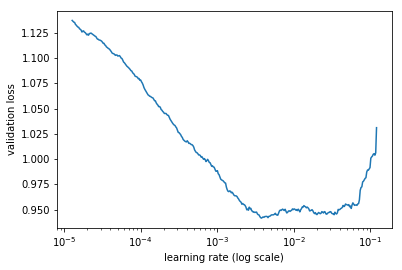

In [153]:
m.lr_find()
m.sched.plot(10)

In [154]:
m.fit(lr, 2, metrics=[accuracy])

epoch      trn_loss   val_loss   accuracy                     
    0      0.921329   0.963663   0.571881  
    1      0.896228   0.962985   0.566078                     



[array([0.96298]), 0.5660775535435577]

In [155]:
# m.fit(lr, 5, cycle_len=1, metrics=[accuracy])

In [156]:
# m.fit(lr, 3, cycle_len=4, cycle_mult=2 , metrics=[accuracy])

In [157]:
m.save(modelName)

In [158]:
m.load(modelName)

## Validation

In [159]:
(x,yl)=m.predict_with_targs()
# x

In [160]:
val = p.train.iloc[val_idx]
val[[dep]]
valpred = pd.DataFrame({
    'Close':val.Close,
    'index':val.index,
    'action':val.action,
    'predicted': np.argmax(x,axis=1),
})[['Close','index', 'action','predicted']]
# valpred


sell_count = str(len(valpred[valpred.predicted == 0]))
hold_count = str(len(valpred[valpred.predicted == 1]))
buy_count = str(len(valpred[valpred.predicted == 2]))
print('Buy count: ' + buy_count + ' Sell count: ' + sell_count + ' Hold count: ' + hold_count)
valpred

Buy count: 51 Sell count: 44 Hold count: 3696


,Close,index,action,predicted
Timestamp,,,,
2018-11-05 12:40:00,6405.709961,2018-11-05 12:40:00,1,1
2018-11-05 12:41:00,6405.700195,2018-11-05 12:41:00,1,1
2018-11-05 12:42:00,6404.410156,2018-11-05 12:42:00,1,1
2018-11-05 12:43:00,6404.939941,2018-11-05 12:43:00,1,1
2018-11-05 12:44:00,6405.629883,2018-11-05 12:44:00,1,1
2018-11-05 12:45:00,6405.709961,2018-11-05 12:45:00,1,1
2018-11-05 12:46:00,6405.709961,2018-11-05 12:46:00,1,1
2018-11-05 12:47:00,6405.000000,2018-11-05 12:47:00,1,1
2018-11-05 12:48:00,6404.410156,2018-11-05 12:48:00,1,1


Calculate the percent accuracy on the validation set

             precision    recall  f1-score   support

          0       0.11      0.00      0.01      1050
          1       0.57      0.98      0.72      2156
          2       0.47      0.04      0.08       585

avg / total       0.43      0.57      0.43      3791

Confusion matrix, without normalization
[[   5 1034   11]
 [  23 2117   16]
 [  16  545   24]]


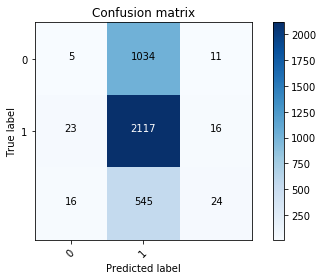

In [161]:
# p.calculate_accuracy_hold(valpred)
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(valpred.action,
                            valpred.predicted,
                            target_names= ['0', '1', '2']))

cm = confusion_matrix(valpred.action, valpred.predicted)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
plot_confusion_matrix(cm, [0, 1])

In [162]:
p.calculate_net_profit_hold(valpred, 15000, 0)
p.result

{'startClose': 6405.71,
 'endClose': 6450.0,
 'startAmount': 15000,
 'endAmount': 14763.268030718224,
 'buyAndHoldPercentIncrease': 0.691,
 'percentIncrease': -1.578,
 'percentDifference': -2.27,
 'totalTrades': 11}

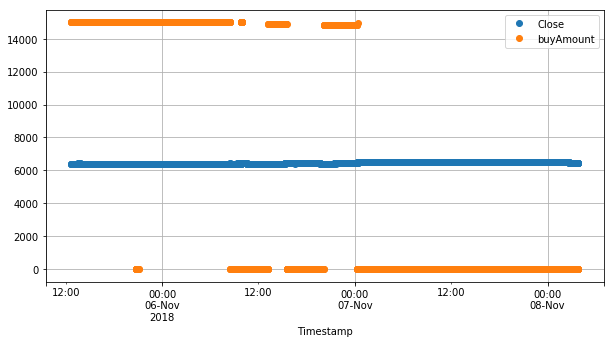

In [163]:
p.plot_profit(p.net_profit_df)

In [164]:
p.net_profit_df

,Timestamp,Close,index,action,predicted,buyAmount,sellAmount
0,2018-11-05 12:40:00,6405.709961,2018-11-05 12:40:00,1,1,15000.0,0.000000
1,2018-11-05 12:41:00,6405.700195,2018-11-05 12:41:00,1,1,15000.0,0.000000
2,2018-11-05 12:42:00,6404.410156,2018-11-05 12:42:00,1,1,15000.0,0.000000
3,2018-11-05 12:43:00,6404.939941,2018-11-05 12:43:00,1,1,15000.0,0.000000
4,2018-11-05 12:44:00,6405.629883,2018-11-05 12:44:00,1,1,15000.0,0.000000
5,2018-11-05 12:45:00,6405.709961,2018-11-05 12:45:00,1,1,15000.0,0.000000
6,2018-11-05 12:46:00,6405.709961,2018-11-05 12:46:00,1,1,15000.0,0.000000
7,2018-11-05 12:47:00,6405.000000,2018-11-05 12:47:00,1,1,15000.0,0.000000
8,2018-11-05 12:48:00,6404.410156,2018-11-05 12:48:00,1,1,15000.0,0.000000
9,2018-11-05 12:49:00,6404.410156,2018-11-05 12:49:00,1,1,15000.0,0.000000


## Test

In [165]:
np.argmax(m.predict(True), axis =1)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

In [166]:
testPred = pd.DataFrame({
    'index':p.test.index,
    'Close':p.test.Close,
    'action':p.test.action, 
    'predicted':np.argmax(m.predict(True), axis =1)
})[['index','Close','action', 'predicted']]
testPred.head(10)

,index,Close,action,predicted
Timestamp,,,,
2018-11-08 03:51:00,2018-11-08 03:51:00,6450.000000,1,1
2018-11-08 03:52:00,2018-11-08 03:52:00,6450.009766,0,1
2018-11-08 03:53:00,2018-11-08 03:53:00,6444.979980,1,1
2018-11-08 03:54:00,2018-11-08 03:54:00,6443.169922,1,1
2018-11-08 03:55:00,2018-11-08 03:55:00,6446.000000,1,1
2018-11-08 03:56:00,2018-11-08 03:56:00,6444.220215,2,1
2018-11-08 03:57:00,2018-11-08 03:57:00,6443.109863,2,1
2018-11-08 03:58:00,2018-11-08 03:58:00,6443.729980,2,1
2018-11-08 03:59:00,2018-11-08 03:59:00,6443.720215,2,1


In [167]:
p.calculate_accuracy_hold(testPred)

{'F1Score': 0.36,
 'totalAccuracy': 0.57,
 'buyAccuracy': 0.075,
 'sellAccuracy': 0.014,
 'hold_accuracy': 0.99,
 'totalSellActions': 1380,
 'totalHoldActions': 2252,
 'totalBuyActions': 358,
 'successfulBuyPredictions': 27}

In [168]:
p.calculate_net_profit_hold(testPred, 15000, 0)
p.result

{'startClose': 6450.0,
 'endClose': 6360.82,
 'startAmount': 15000,
 'endAmount': 14974.537837385808,
 'buyAndHoldPercentIncrease': -1.383,
 'percentIncrease': -0.17,
 'percentDifference': 1.213,
 'totalTrades': 4}

In [169]:
p.net_profit_df

,index,Close,action,predicted,buyAmount,sellAmount
Timestamp,,,,,,
2018-11-08 03:51:00,2018-11-08 03:51:00,6450.000000,1,1,15000.000000,0.0
2018-11-08 03:52:00,2018-11-08 03:52:00,6450.009766,0,1,15000.000000,0.0
2018-11-08 03:53:00,2018-11-08 03:53:00,6444.979980,1,1,15000.000000,0.0
2018-11-08 03:54:00,2018-11-08 03:54:00,6443.169922,1,1,15000.000000,0.0
2018-11-08 03:55:00,2018-11-08 03:55:00,6446.000000,1,1,15000.000000,0.0
2018-11-08 03:56:00,2018-11-08 03:56:00,6444.220215,2,1,15000.000000,0.0
2018-11-08 03:57:00,2018-11-08 03:57:00,6443.109863,2,1,15000.000000,0.0
2018-11-08 03:58:00,2018-11-08 03:58:00,6443.729980,2,1,15000.000000,0.0
2018-11-08 03:59:00,2018-11-08 03:59:00,6443.720215,2,1,15000.000000,0.0


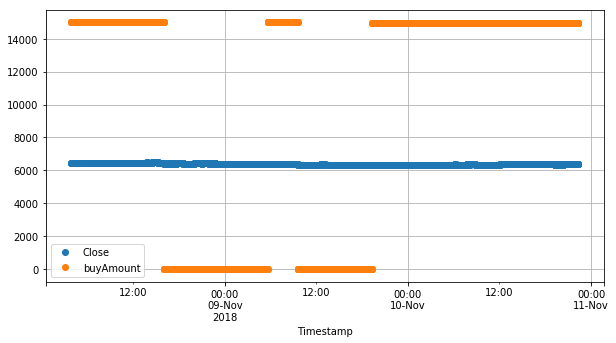

In [170]:
p.plot_profit(p.net_profit_df)

## Playground

In [171]:
# list(p.train.columns.values)
m.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [172]:
# val_idx
# y